# 出租车数据的地理信息处理
## 读取shp文件
* .shp 存储的是几何要素的的空间信息，也就是XY坐标
* .shx 存储的是有关*.shp存储的索引信息。它记录了在*.shp中，空间数据是如何存储的，XY坐标的输入点在哪里，有多少XY坐标对等信息
* .dbf 存储地理数据的属性信息的dBase表

<AxesSubplot:>

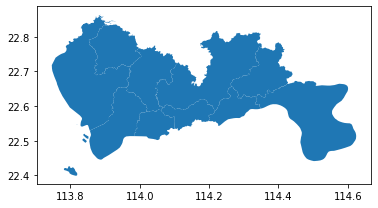

In [62]:
#导入必要的包
import pandas as pd
import numpy as np
#绘制图用的包
import matplotlib as mpl
import matplotlib.pyplot as plt
#geopandas包
import geopandas 
#shapely包
from shapely.geometry import point,Polygon,shape
#读取shapefile文件
shp = '/home/liu/Documents/pygeo-tutorial/shapefile/sz.shp'
sz = geopandas.GeoDataFrame.from_file(shp,encoding = 'utf-8')
#绘制
sz.plot()

In [63]:
sz.head(5)

,centroid_x,centroid_y,qh,geometry
0,114.143157,22.577605,罗湖,"POLYGON ((114.10006 22.53431, 114.09969 22.535..."
1,114.041535,22.546180,福田,"POLYGON ((113.98578 22.51348, 113.98558 22.523..."
2,114.270206,22.596432,盐田,"POLYGON ((114.22772 22.54290, 114.22643 22.543..."
3,113.851387,22.679120,宝安,"MULTIPOLYGON (((113.81831 22.54676, 113.81816 ..."
4,113.926290,22.766157,光明,"POLYGON ((113.98587 22.80304, 113.98605 22.802..."


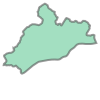

In [64]:
sz['geometry'].iloc[2]

In [65]:
type(sz['geometry'].iloc[0])

shapely.geometry.polygon.Polygon

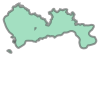

In [66]:
#用unary_union可以将一个geopandas的所有记录合并为一个图形,合并出来的结果是Polygon
sz.unary_union

## 栅格化
我们需要能够直接批量算出来一批经纬度的栅格编号  
栅格化的原理  
栅格编号(loncol,latcol)  
栅格中心点坐标(hblon,hblat)

每个网格的长度:  
$$x = 500$$
计算每个网格的经度和纬度增加:
$$\Delta Lon = \frac{x\cdot 360}{2\pi\cdot R_e\cdot cos(\frac{(lat_1-lat_2)\cdot \pi}{360})}$$
$$\Delta Lat =\frac{x\cdot 360}{2\pi\cdot R_e}$$
$R_e:地球半径$

计算每个网格的坐标ID:  
$$LonID = \frac{m-(lon_1-\frac{\Delta Lon}{2})}{\Delta Lon}$$
$$LonID = \frac{a-(lat_1-\frac{\Delta Lat}{2})}{\Delta Lat}$$

m：输入点的经度

n：输入点的纬度

In [67]:
#栅格化代码
import math
testlon = 114
testlat = 22.5

#划定栅格划分范围
lon1 = 113.75194
lon2 = 114.624187
lat1 = 22.447837
lat2 = 22.864748

latStart = min(lat1,lat2)
lonStart = min(lon1,lon2)

#定义栅格大小
accuracy = 500

#计算栅格经纬度增加量大小 \Delta Lon和\Delta Lat
deltaLon = accuracy * 360/(2 * math.pi * 6371004 * math.cos((lat1 + lat2) * math.pi /360))
deltaLat = accuracy * 360/(2 * math.pi * 6371004)

#计算栅格的经纬度编号
LONCOL=divmod(float(testlon) - (lonStart - deltaLon / 2) , deltaLon)[0]
LATCOL=divmod(float(testlat) - (latStart - deltaLat / 2) , deltaLat)[0] 
#divmod() 函数把除数和余数运算结果结合起来，返回一个包含商和余数的元组(a // b, a % b)

#计算栅格的中心点经纬度
HBLON = LONCOL*deltaLon + (lonStart - deltaLon/2)
HBLAT = LATCOL*deltaLon + (latStart - deltaLat/2)
#格子编号*格子宽+起始坐标-半个格子宽 = 格子中心横坐标

LONCOL,LATCOL,HBLON,HBLAT,deltaLon,deltaLat

(51.0,
 12.0,
 113.99800701150498,
 22.504060066467282,
 0.004872614089207591,
 0.004496605206422906)

生成栅格的geopandas数据

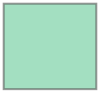

In [68]:
from shapely.geometry import Point,Polygon,shape
Polygon([(HBLON+deltaLon/2,HBLAT-deltaLat/2),
        (HBLON+deltaLon/2,HBLAT+deltaLat/2),
        (HBLON-deltaLon/2,HBLAT+deltaLat/2),
        (HBLON-deltaLon/2,HBLAT-deltaLat/2)])#多边形建模

<AxesSubplot:>

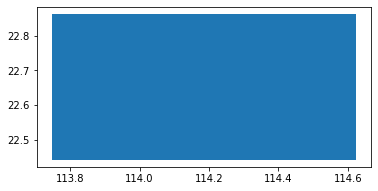

In [69]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import geopandas
from shapely.geometry import Point,Polygon,shape

#定义空geopandas表
data = geopandas.GeoDataFrame()

#定义空的list,后面循环一次就往里面加东西
LONCOL = []
LATCOL = []
geometry = []
HBLON1 = []
HBLAT1 = []

#计算总共要生成多少个栅格
lonsnum = int((lon2-lon1)/deltaLon)+1
latsnum = int((lat2-lat1)/deltaLat)+1

for i in range(lonsnum):
    for j in range(latsnum):
        HBLON = i*deltaLon + (lonStart - deltaLon/2)
        HBLAT = j*deltaLat + (latStart - deltaLat/2)
        LONCOL.append(i)
        LATCOL.append(j)
        HBLON1.append(HBLON)
        HBLAT1.append(HBLAT)
        
        #生成栅格的Polygon形状
        #这里我们用周围的栅格推算三个顶点的位置,否则生成的栅格因为小数点取值问题出现小缝隙
        HBLON_1 = (i+1)*deltaLon + (lonStart - deltaLon / 2)
        HBLAT_1 = (j+1)*deltaLat + (latStart - deltaLat / 2)
        geometry.append(Polygon([
        (HBLON-deltaLon/2,HBLAT-deltaLat/2),
        (HBLON_1-deltaLon/2,HBLAT-deltaLat/2),
        (HBLON_1-deltaLon/2,HBLAT_1-deltaLat/2),
        (HBLON-deltaLon/2,HBLAT_1-deltaLat/2)]))
        
#为geopandas文件的每一列赋值为刚刚的list
data['LONCOL'] = LONCOL
data['LATCOL'] = LATCOL
data['HBLON'] = HBLON1
data['HBLAT'] = HBLAT1
data['geometry'] = geometry

data.plot()

In [70]:
data.head(5)

,LONCOL,LATCOL,HBLON,HBLAT,geometry
0,0,0,113.749504,22.445589,"POLYGON ((113.74707 22.44334, 113.75194 22.443..."
1,0,1,113.749504,22.450085,"POLYGON ((113.74707 22.44784, 113.75194 22.447..."
2,0,2,113.749504,22.454582,"POLYGON ((113.74707 22.45233, 113.75194 22.452..."
3,0,3,113.749504,22.459079,"POLYGON ((113.74707 22.45683, 113.75194 22.456..."
4,0,4,113.749504,22.463575,"POLYGON ((113.74707 22.46133, 113.75194 22.461..."


<AxesSubplot:>

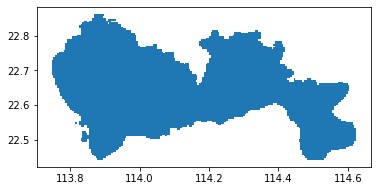

In [84]:
grid = data[data.intersects(sz.unary_union)]
grid.plot()

In [72]:
#保存
grid.to_file('/home/liu/Documents/pygeo-tutorial/shapefile/grid',encoding = 'utf-8')

## 将数据对应到栅格

In [106]:
import pandas as pd
TaxiOD = pd.read_csv('/home/liu/Documents/pygeo-tutorial/data-sample/TaxiOD.csv')
TaxiOD.columns = ['VehicleNum', 'Stime', 'SLng', 'SLat', 
       'ELng', 'ELat','Etime']
TaxiOD.head(5)

,VehicleNum,Stime,SLng,SLat,ELng,ELat,Etime
0,22223,00:03:23,114.167465,22.562468,114.225235,22.552750,00:10:48
1,22223,00:11:33,114.227150,22.554167,114.229218,22.560217,00:15:19
2,22223,00:17:13,114.231354,22.562166,114.255798,22.590967,00:29:06
3,22223,00:36:45,114.240196,22.563650,114.119965,22.566668,00:54:42
4,22223,01:01:14,114.135414,22.575933,114.166748,22.608267,01:08:17


In [107]:
TaxiOD = TaxiOD[-TaxiOD['ELng'].isnull()].copy() #copy() 函数返回一个字典的浅复制
#计算起点栅格的经纬度编号
TaxiOD['SLONCOL'] = ((TaxiOD['SLng'] - (lonStart - deltaLon / 2))/deltaLon).astype('int')
TaxiOD['SLATCOL'] = ((TaxiOD['SLat'] - (latStart - deltaLat / 2))/deltaLat).astype('int')
#计算起点栅格的中心点经纬度
TaxiOD['SHBLON'] = TaxiOD['SLONCOL']*deltaLon + (lonStart - deltaLon / 2)
TaxiOD['SHBLAT'] = TaxiOD['SLATCOL']*deltaLat + (latStart - deltaLat / 2)
#计算终点栅格的经纬度编号
TaxiOD['ELONCOL'] = ((TaxiOD['ELng'] - (lonStart - deltaLon / 2))/deltaLon).astype('int')
TaxiOD['ELATCOL'] = ((TaxiOD['ELat'] - (latStart - deltaLat / 2))/deltaLat).astype('int') 
#计算终点栅格的中心点经纬度
TaxiOD['EHBLON'] = TaxiOD['ELONCOL']*deltaLon + (lonStart - deltaLon / 2)
TaxiOD['EHBLAT'] = TaxiOD['ELATCOL']*deltaLat + (latStart - deltaLat / 2)
#筛选去掉起点终点在同一个格子里的OD
TaxiOD = TaxiOD[-((TaxiOD['SLONCOL']==TaxiOD['ELONCOL'])&(TaxiOD['SLATCOL']==TaxiOD['ELATCOL']))]
#筛选去掉不在研究范围内的栅格，TaxiOD的LONCOL、LATCOL都需要在我们的范围内
TaxiOD = TaxiOD[(TaxiOD['SLONCOL']>=0) & (TaxiOD['SLATCOL']>=0) &(TaxiOD['ELONCOL']>=0) & (TaxiOD['ELATCOL']>=0)&
(TaxiOD['SLONCOL']<=lonsnum) & (TaxiOD['SLATCOL']<=latsnum) &(TaxiOD['ELONCOL']<=lonsnum) & (TaxiOD['ELATCOL']<=latsnum)]

TaxiOD.head(5)

,VehicleNum,Stime,SLng,SLat,ELng,ELat,Etime,SLONCOL,SLATCOL,SHBLON,SHBLAT,ELONCOL,ELATCOL,EHBLON,EHBLAT
0,22223,00:03:23,114.167465,22.562468,114.225235,22.552750,00:10:48,85,25,114.163676,22.558004,97,23,114.222147,22.549011
1,22223,00:11:33,114.227150,22.554167,114.229218,22.560217,00:15:19,98,24,114.227020,22.553507,98,25,114.227020,22.558004
2,22223,00:17:13,114.231354,22.562166,114.255798,22.590967,00:29:06,98,25,114.227020,22.558004,103,32,114.251383,22.589480
3,22223,00:36:45,114.240196,22.563650,114.119965,22.566668,00:54:42,100,26,114.236765,22.562500,76,26,114.119822,22.562500
4,22223,01:01:14,114.135414,22.575933,114.166748,22.608267,01:08:17,79,28,114.134440,22.571494,85,36,114.163676,22.607466


## 集计栅格OD(全天 高峰时段)

In [108]:
OD = TaxiOD.groupby(['SLONCOL','SLATCOL','ELONCOL','ELATCOL'])['VehicleNum'].count().reset_index()
OD = OD.sort_values(by = 'VehicleNum',ascending = False)

## 绘制栅格的OD图
### 先绘制前20行


In [109]:
#取前20的OD
Topod = OD.iloc[:20].copy()

#计算起点栅格的中心点经纬度
Topod['SHBLON'] = Topod['SLONCOL'] * deltaLon + (lonStart - deltaLon / 2)
Topod['SHBLAT'] = Topod['SLATCOL'] * deltaLat + (latStart - deltaLat / 2)

#计算终点栅格的中心点经纬度
Topod['EHBLON'] = Topod['ELONCOL'] * deltaLon + (lonStart - deltaLon / 2)
Topod['EHBLAT'] = Topod['ELATCOL'] * deltaLat + (latStart - deltaLat / 2)
Topod.head()

,SLONCOL,SLATCOL,ELONCOL,ELATCOL,VehicleNum,SHBLON,SHBLAT,EHBLON,EHBLAT
113365,63,17,65,16,298,114.056478,22.522031,114.066224,22.517534
155022,75,21,74,19,275,114.114950,22.540017,114.110077,22.531024
113808,63,18,65,16,235,114.056478,22.526528,114.066224,22.517534
160281,76,21,74,19,173,114.119822,22.540017,114.110077,22.531024
122609,65,17,63,18,172,114.066224,22.522031,114.056478,22.526528


In [110]:
#导入绘图包
import matplotlib as mpl
import matplotlib.pyplot as plt

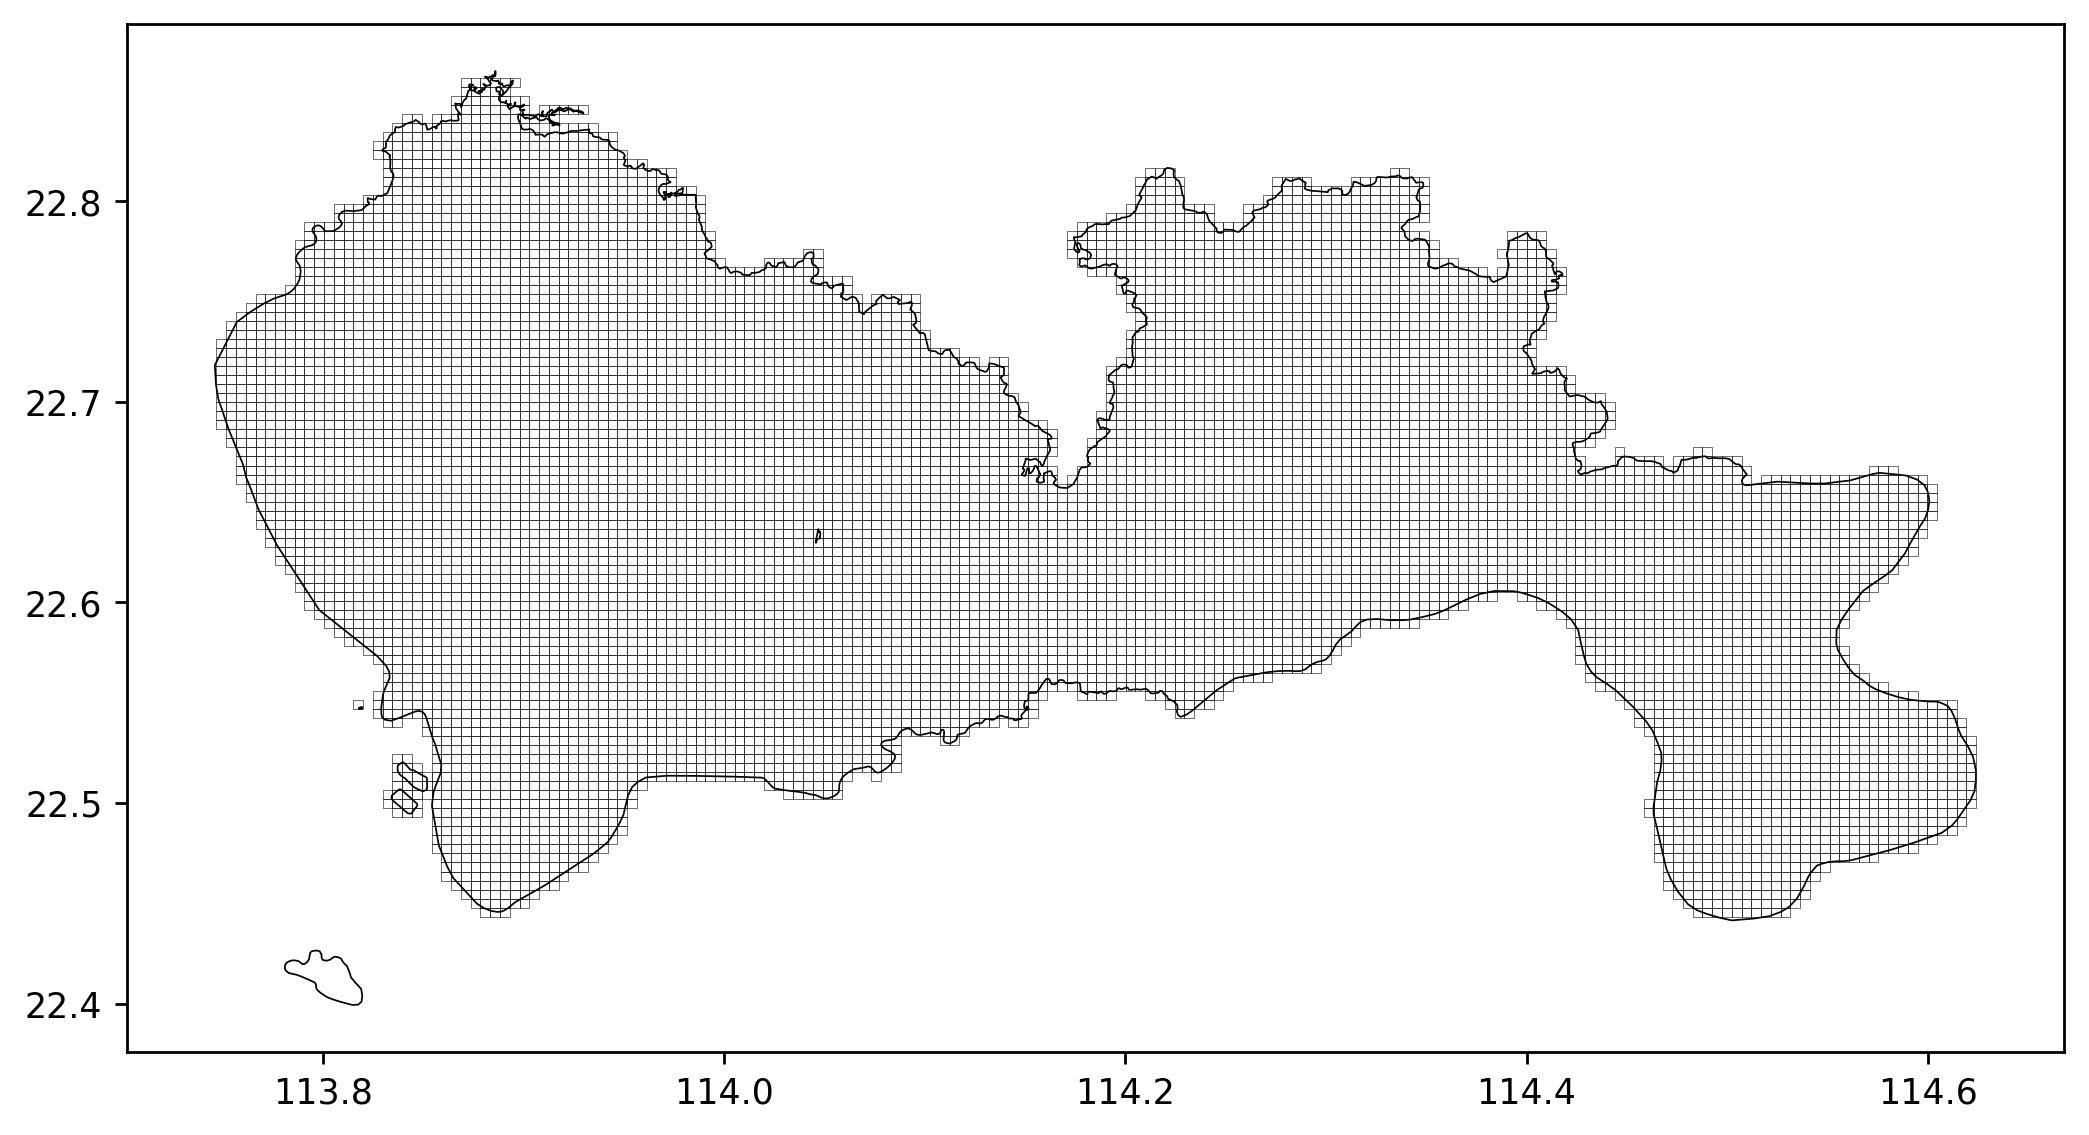

In [111]:
fig     = plt.figure(1,(10,8),dpi = 250)    
ax      = plt.subplot(111)
plt.sca(ax)

#把刚才生成的栅格在ax上绘制
grid.plot(ax =ax,edgecolor = (0,0,0,0.8),facecolor = (0,0,0,0),linewidths=0.2)

#把合并的行政区划变成一个geopandas，在ax上绘制
SZ_all = geopandas.GeoDataFrame()
SZ_all['geometry'] = [sz.unary_union]
SZ_all.plot(ax = ax,edgecolor = (0,0,0,1),facecolor = (0,0,0,0),linewidths=0.5)

plt.show()

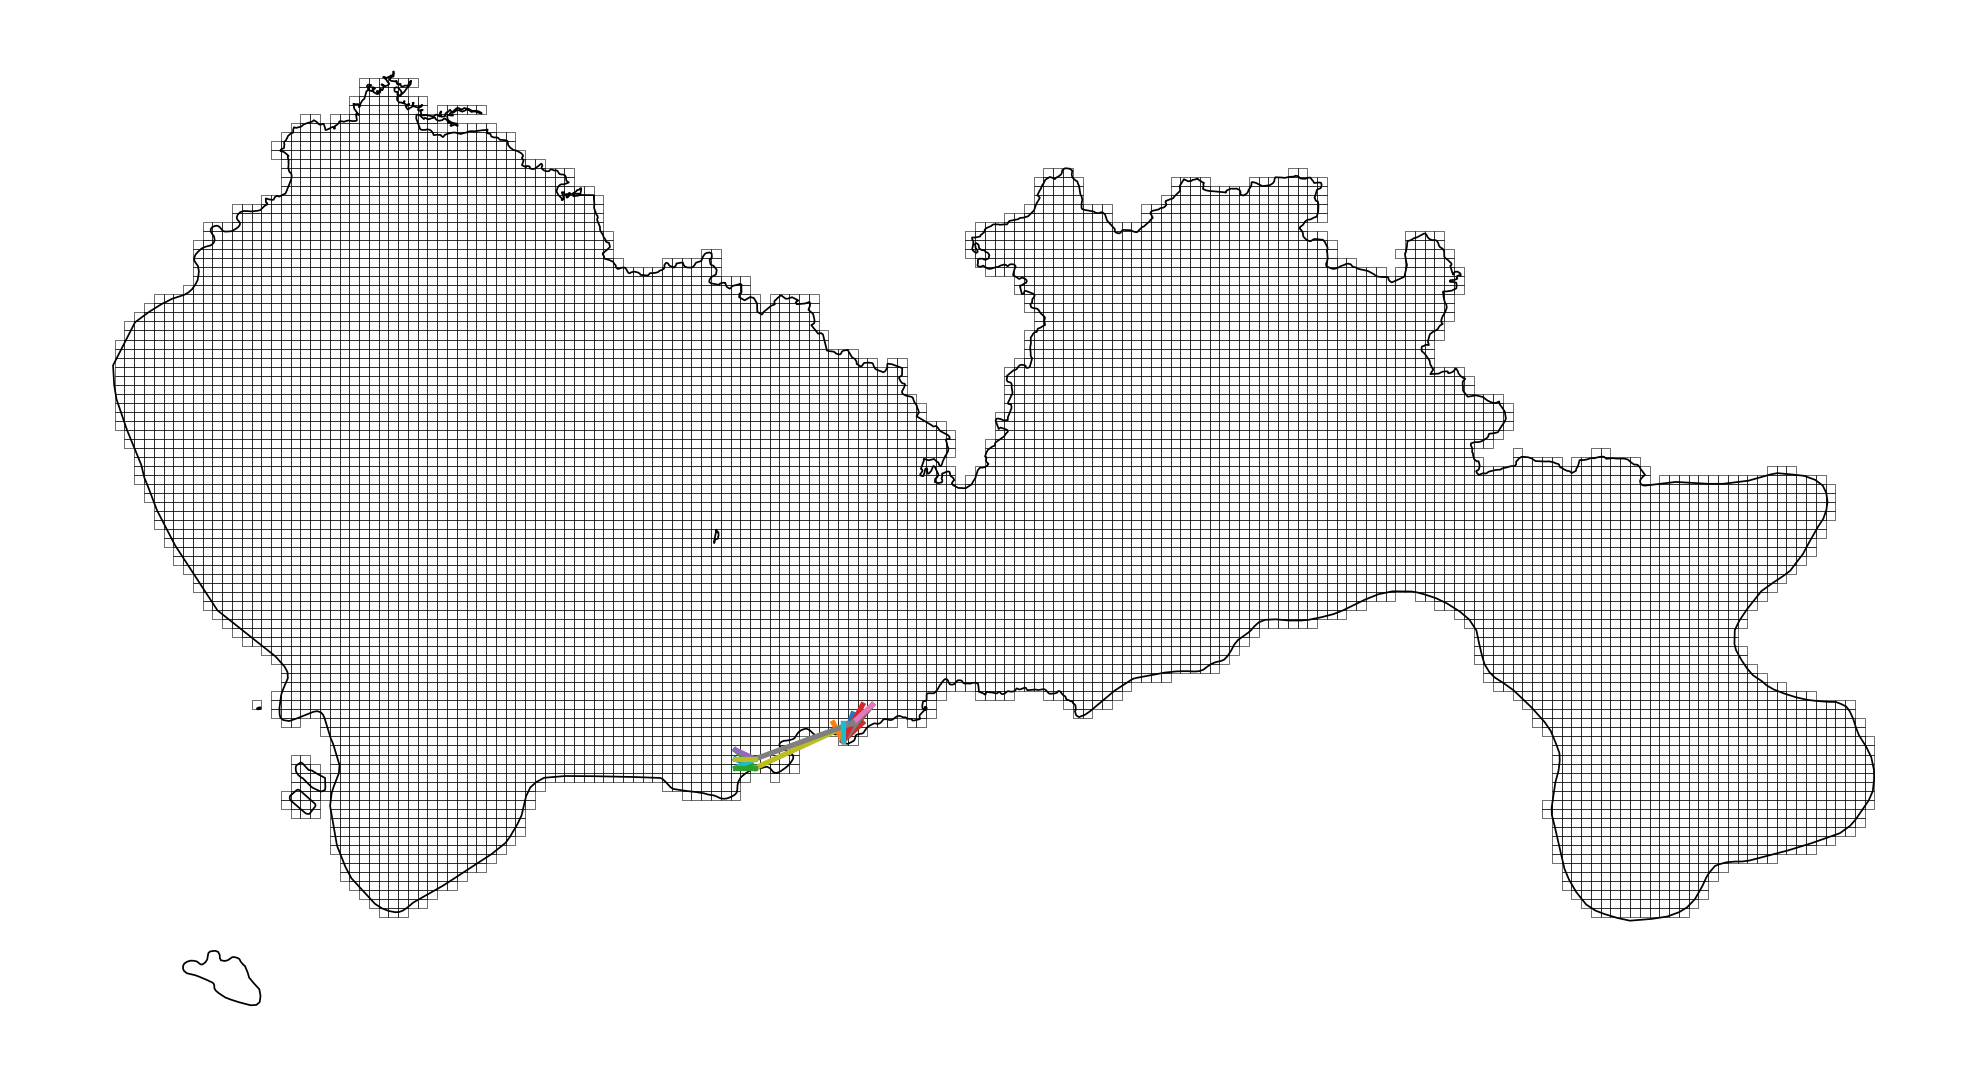

In [112]:
fig     = plt.figure(1,(10,8),dpi = 250)    
ax      = plt.subplot(111)
plt.sca(ax)

grid.plot(ax =ax,edgecolor = (0,0,0,0.8),facecolor = (0,0,0,0),linewidths=0.2)
SZ_all.plot(ax = ax,edgecolor = (0,0,0,1),facecolor = (0,0,0,0),linewidths=0.5)

for i in range(len(Topod)):

    
    plt.plot([Topod['SHBLON'].iloc[i],Topod['EHBLON'].iloc[i]],[Topod['SHBLAT'].iloc[i],Topod['EHBLAT'].iloc[i]])


#不显示坐标轴
plt.axis('off')

plt.show()

### 画出全部的OD

In [114]:
OD1 = OD[OD['VehicleNum']>10].copy()

#OD从小到大排序方便我们后续操作，因为我们希望小的OD先画，放在最底下，大的OD后画，放在最上面
OD1 = OD1.sort_values(by = 'VehicleNum')

#计算起点栅格的中心点经纬度
OD1['SHBLON'] = OD1['SLONCOL'] * deltaLon + (lonStart - deltaLon / 2)
OD1['SHBLAT'] = OD1['SLATCOL'] * deltaLat + (latStart - deltaLat / 2)

#计算终点栅格的中心点经纬度
OD1['EHBLON'] = OD1['ELONCOL'] * deltaLon + (lonStart - deltaLon / 2)
OD1['EHBLAT'] = OD1['ELATCOL'] * deltaLat + (latStart - deltaLat / 2)

#对OD分5组，生成一个取值为0-1的列，每组的值相同，用以表示OD的粗细，取名linewidth
step = 5
OD1['linewidth'] = (np.array(range(len(OD1)))*step/len(OD1)).astype('int')/step+0.1
OD1.head(5)

,SLONCOL,SLATCOL,ELONCOL,ELATCOL,VehicleNum,SHBLON,SHBLAT,EHBLON,EHBLAT,linewidth
41465,37,17,34,21,11,113.929790,22.522031,113.915173,22.540017,0.1
93970,59,27,61,20,11,114.036988,22.566997,114.046733,22.535521,0.1
149728,74,20,76,27,11,114.110077,22.535521,114.119822,22.566997,0.1
38433,36,18,37,18,11,113.924918,22.526528,113.929790,22.526528,0.1
138355,71,23,68,23,11,114.095459,22.549011,114.080841,22.549011,0.1


绘制OD用时 5.278459548950195 秒


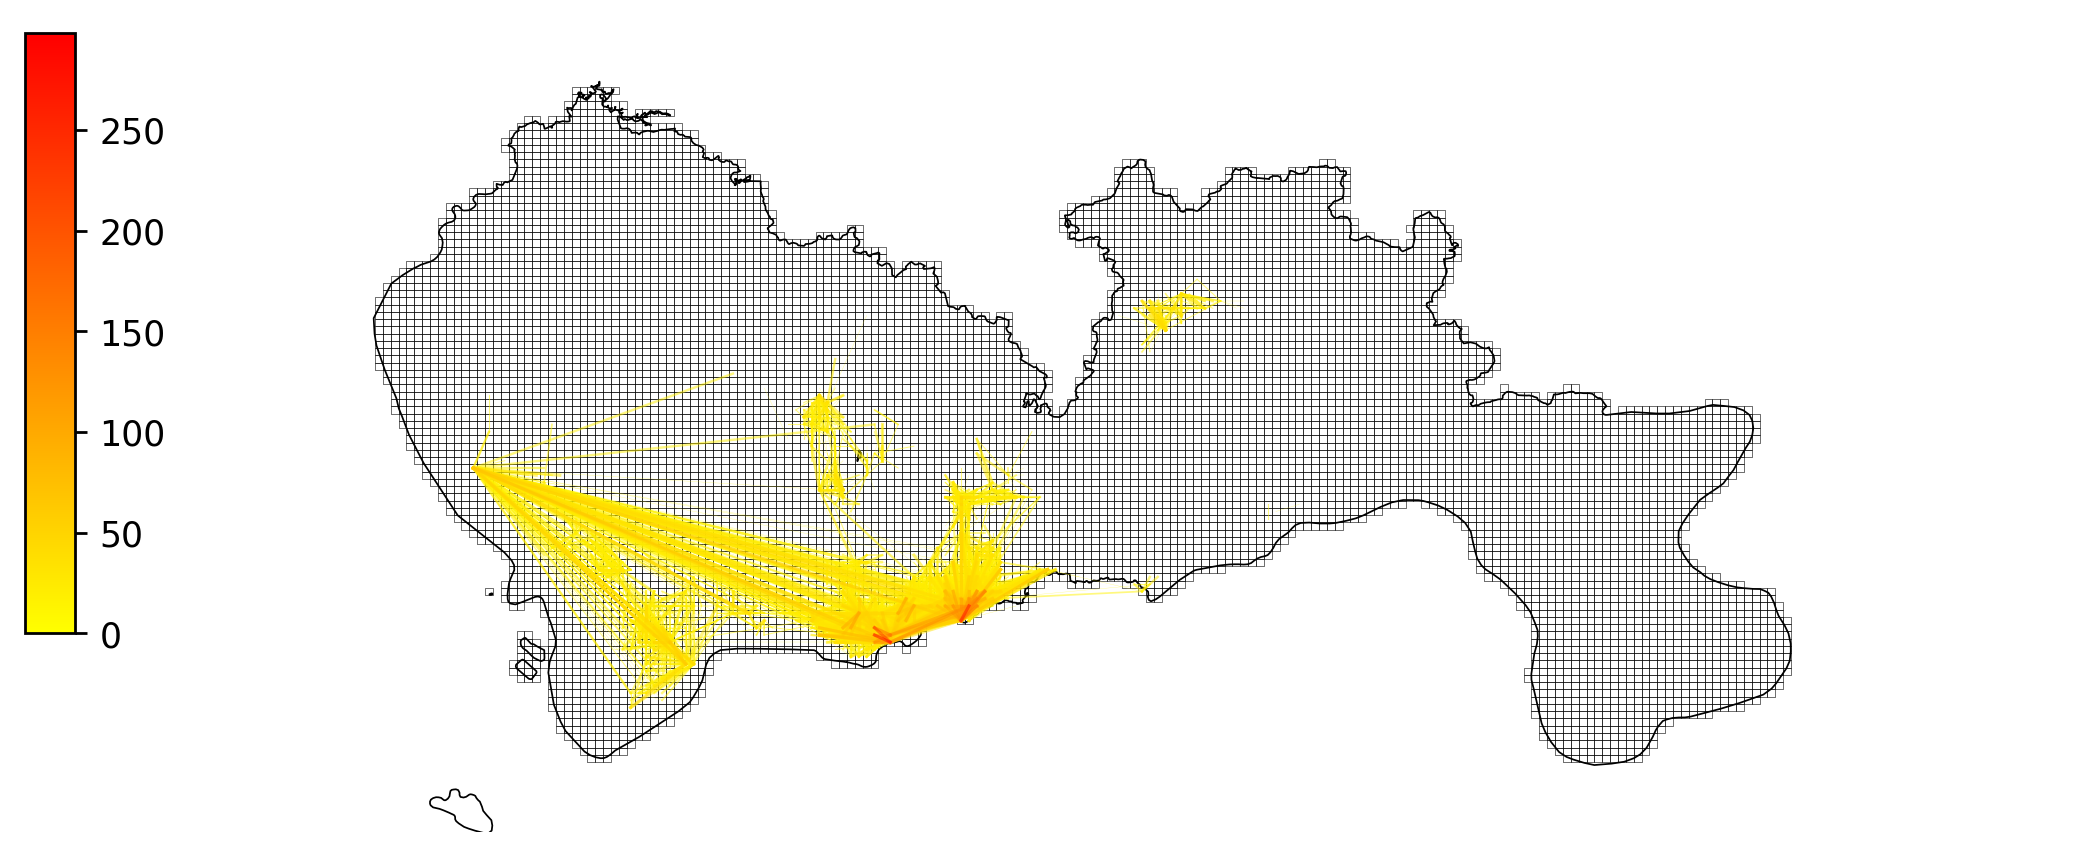

In [142]:
import time
fig     = plt.figure(1,(10,8),dpi = 250)    
ax      = plt.subplot(111)
plt.sca(ax)

#把刚才生成的栅格在ax上绘制
grid.plot(ax = ax,edgecolor = (0,0,0,0.8),facecolor = (0,0,0,0),linewidths=0.2)

#绘制整个深圳的范围
SZ_all.plot(ax = ax,edgecolor = (0,0,0,1),facecolor = (0,0,0,0),linewidths=0.5)

#设置colormap的数据
import matplotlib
vmax = OD['VehicleNum'].max()
#设定一个标准化的工具，设定OD的colormap最大最小值，他的作用是norm(count)就会将count标准化到0-1的范围内
norm = mpl.colors.Normalize(vmin=0,vmax=vmax)
#设定colormap的颜色
cmapname = 'autumn_r'
#cmap是一个获取颜色的工具，cmap(a)会返回颜色，其中a是0-1之间的值
cmap = matplotlib.cm.get_cmap(cmapname)

#绘制OD
timeflag = time.time()
for i in range(len(OD1)):
    ###########################你需要在下面写代码#############################
    #设定plt.plot里面的参数alpha和color和linewidth
    plt.plot([OD1['SHBLON'].iloc[i],OD1['EHBLON'].iloc[i]],[OD1['SHBLAT'].iloc[i],OD1['EHBLAT'].iloc[i]],\
            linewidth = OD1['linewidth'].iloc[i],color = cmap(norm(OD1['VehicleNum'].iloc[i])),alpha=0.5)
    
    ###################################################################################
print('绘制OD用时',time.time()-timeflag,'秒')
    
#不显示坐标轴
plt.axis('off')    

#绘制假的colorbar，这是因为，我们画的OD是线，没办法直接画出来colorbar
#所以我们在一个看不见的地方画了一个叫imshow的东西，他的范围是0到vmax
#然后我们再对imshow添加colorbar
plt.imshow([[0,vmax]], cmap=cmap)
#设定colorbar的大小和位置
cax = plt.axes([0.08, 0.4, 0.02, 0.3])
plt.colorbar(cax=cax)

#然后要把镜头调整回到深圳地图那，不然镜头就在imshow那里了


ax.set_xlim(113.6,114.8)
ax.set_ylim(22.4,22.9)



plt.show()

In [143]:
len(OD1)

5319

### 用GeoDataFrame自带plot函数绘制
如果遍历绘制OD，绘制速度比较慢，绘制5319条OD用时31s。
但是，如果把DataFrame变成GeoDataFrame，然后用自带的plot函数绘制，会快很多

In [147]:
from shapely.geometry import LineString
OD1['geometry'] = OD1.apply(lambda r:LineString([[r['SHBLON'],r['SHBLAT']],[r['EHBLON'],r['EHBLAT']]]),axis = 1)
#LineStrings构造函数传入参数是2个或多个点序列,返回坐标
OD1 = geopandas.GeoDataFrame(OD1)

绘制底图用时 1.735227346420288 秒
绘制OD用时 0.26875901222229004 秒


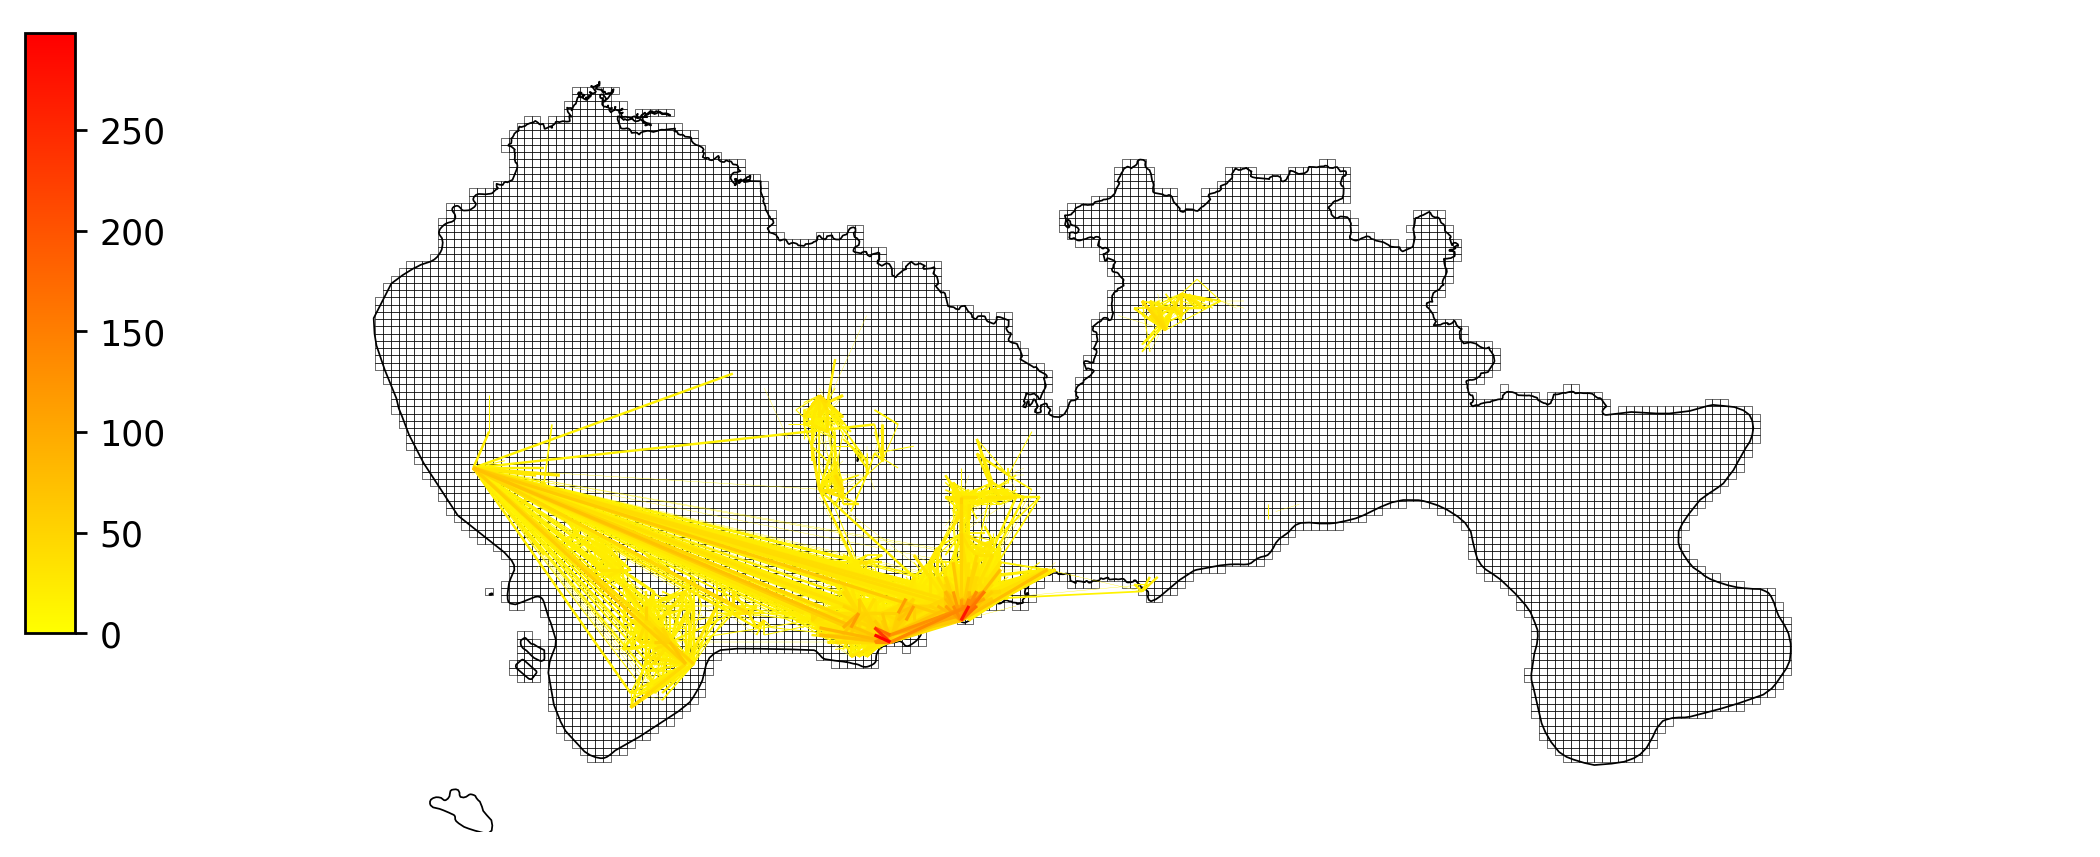

In [148]:
fig     = plt.figure(1,(10,8),dpi = 250)    
ax      = plt.subplot(111)
plt.sca(ax)

#计时
import time
timeflag = time.time()
#绘制底图
grid.plot(ax = ax,edgecolor = (0,0,0,0.8),facecolor = (0,0,0,0),linewidths=0.2)
SZ_all.plot(ax = ax,edgecolor = (0,0,0,1),facecolor = (0,0,0,0),linewidths=0.5)
print('绘制底图用时',time.time()-timeflag,'秒')


#设置colormap的数据
import matplotlib
vmax = OD['VehicleNum'].max()
cmapname = 'autumn_r'
cmap = matplotlib.cm.get_cmap(cmapname)

timeflag = time.time()
#绘制OD
OD1.plot(ax = ax,column = 'VehicleNum',vmax = vmax,vmin = 0,cmap = cmap,linewidth = OD1['linewidth'])
print('绘制OD用时',time.time()-timeflag,'秒')

plt.axis('off')    
plt.imshow([[0,vmax]], cmap=cmap)
cax = plt.axes([0.08, 0.4, 0.02, 0.3])
plt.colorbar(cax=cax)
ax.set_xlim(113.6,114.8)
ax.set_ylim(22.4,22.9)
plt.show()

In [149]:
#集计
Odistribution = OD.groupby(['SLONCOL','SLATCOL'])['VehicleNum'].sum().reset_index()

In [152]:
#将集计的结果与栅格的geopandas执行merge操作
gridtoplot = pd.merge(grid,Odistribution.rename(columns = {'SLONCOL':'LONCOL','SLATCOL':'LATCOL'}),on = ['LONCOL','LATCOL'])
gridtoplot = gridtoplot.rename(columns = {'VehicleNum':'count'})

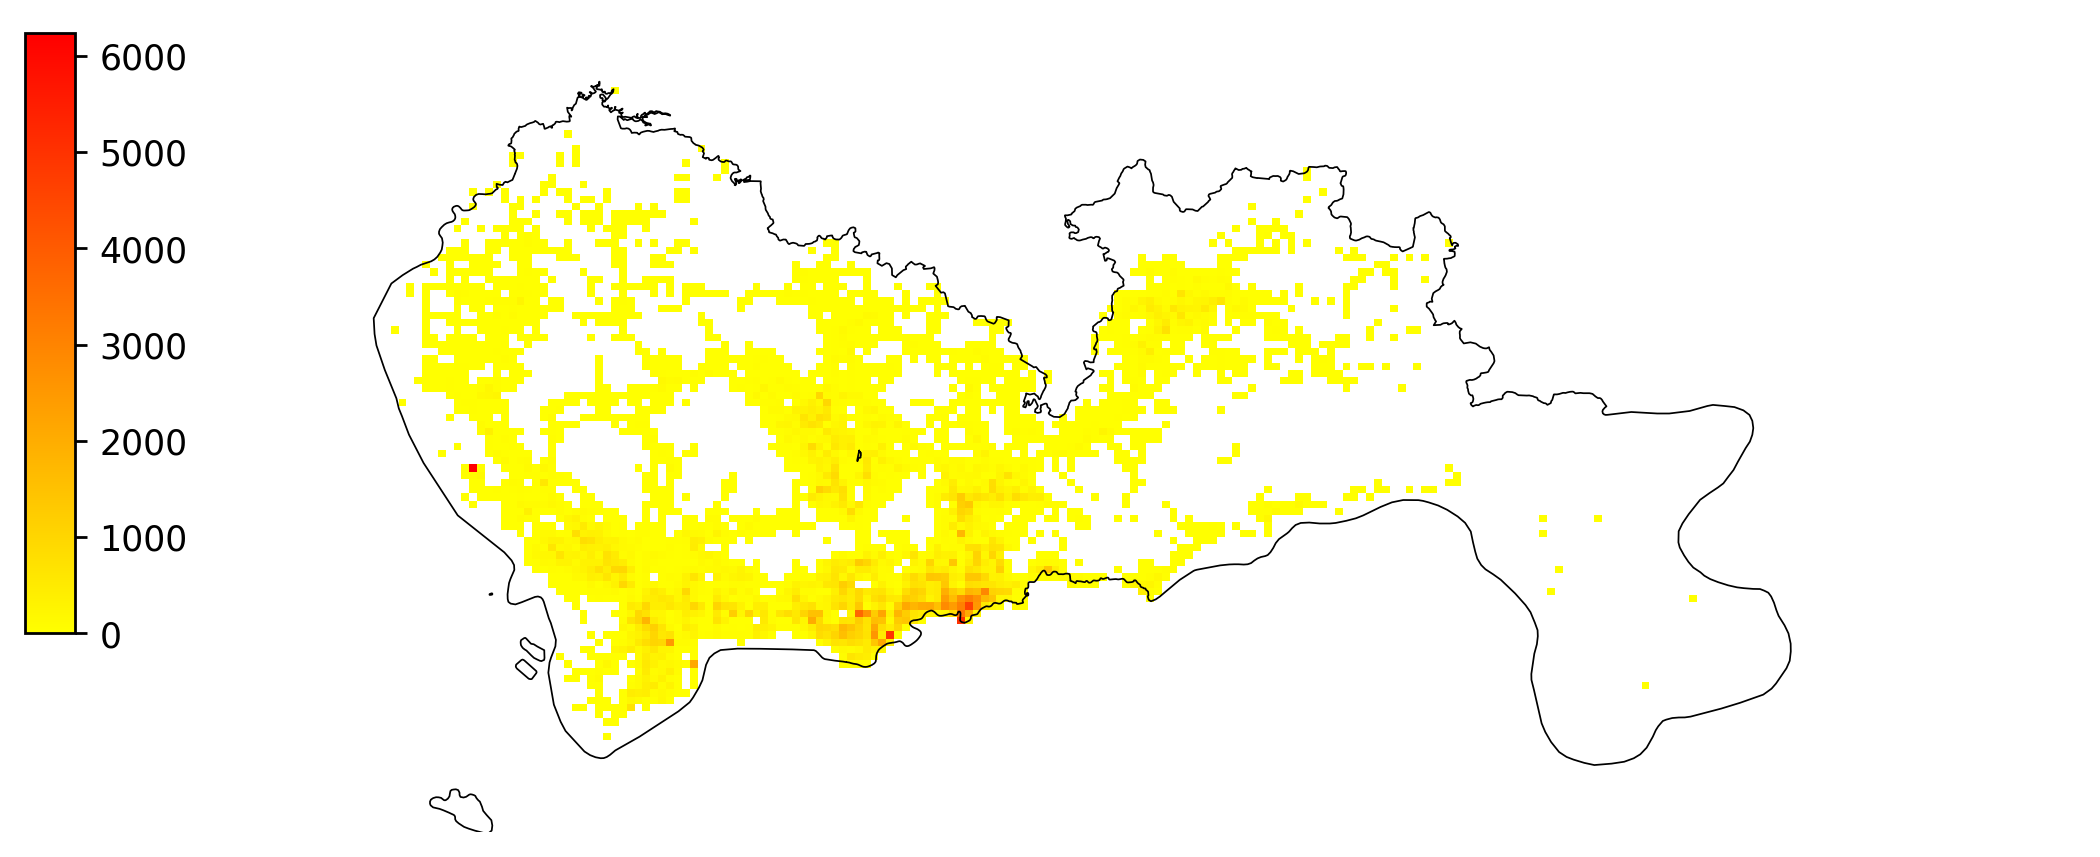

In [154]:
fig     = plt.figure(1,(10,8),dpi = 250)    
ax      = plt.subplot(111)
plt.sca(ax)

#设置colormap的数据
import matplotlib
vmax = gridtoplot['count'].max()
#设定一个标准化的工具，设定OD的colormap最大最小值，他的作用是norm(count)就会将count标准化到0-1的范围内
norm = mpl.colors.Normalize(vmin=0,vmax=vmax)
#设定colormap的颜色
cmapname = 'autumn_r'
#cmap是一个获取颜色的工具，cmap(a)会返回颜色，其中a是0-1之间的值
cmap = matplotlib.cm.get_cmap(cmapname)


#将gridtoplot这个geodataframe进行绘制
#提示：用gridtoplot.plot，设定里面的参数是column = 'count'，以count这一列来绘制。参数cmap = cmap设定它的颜色
###########################你需要在下面写代码#############################
#gridtoplot.plot(...)
gridtoplot.plot(ax = ax, column = 'count', vmax = vmax, vmin=0, cmap = cmap)

###################################################################################

#绘制整个深圳的范围
SZ_all.plot(ax = ax,edgecolor = (0,0,0,1),facecolor = (0,0,0,0),linewidths=0.5)


#不显示坐标轴
plt.axis('off')    

#绘制假的colorbar，这是因为，我们画的OD是线，没办法直接画出来colorbar
#所以我们在一个看不见的地方画了一个叫imshow的东西，他的范围是0到vmax
#然后我们再对imshow添加colorbar
plt.imshow([[0,vmax]], cmap=cmap)
#设定colorbar的大小和位置
cax = plt.axes([0.08, 0.4, 0.02, 0.3])
plt.colorbar(cax=cax)




#然后要把镜头调整回到深圳地图那，不然镜头就在imshow那里了


ax.set_xlim(113.6,114.8)
ax.set_ylim(22.4,22.9)

plt.show()